In [8]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


def extract_numbers(filename):
    """파일 이름에서 실험 번호와 샘플 번호를 추출합니다.

    Args:
        filename (str): 파일 이름 (예: 'T1_1_Expt_1_2.csv')

    Returns:
        tuple: 추출된 숫자들 (T 번호, 샘플 번호, 실험 번호)을 반환합니다.
        None: 파일 이름이 형식에 맞지 않으면 None을 반환합니다.
    """
    match = re.match(r'T(\d+)_(\d+)_Expt_(\d+)_(\d+).csv', filename)
    if match:
        T, S, E, _ = map(int, match.groups())
        return T, S, E
    print('No match')
    return None


def combine_data(dir_path, Tnum, sensor='Accelerometer'):
    """주어진 디렉토리에서 특정 센서 데이터를 통합하여 DataFrame으로 반환합니다.

    Args:
        dir_path (str): 데이터 파일이 저장된 디렉토리 경로
        Tnum (str): 실험 번호 디렉토리 (예: 'T1')
        sensor (str): 센서 유형 (예: 'Accelerometer', 기본값: 'Accelerometer')

    Returns:
        pandas.DataFrame: 통합된 센서 데이터
    """
    dfs = []
    path = os.path.join(dir_path, Tnum, sensor)
    if os.path.exists(path):
        sorted_files = sorted(os.listdir(
            path), key=lambda x: extract_numbers(x))
        for file in sorted_files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, file))
                _, S, E = extract_numbers(file)
                df['sample'] = S
                df['Expt'] = E

                dfs.append(df)
    else:
        print(f'{path} not found')
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def downsampling(ACC, FOR):
    """가속도계 데이터를 힘 센서 데이터의 크기와 맞추기 위해 다운샘플링합니다.

    Args:
        ACC (pandas.DataFrame): 가속도계 데이터
        FOR (pandas.DataFrame): 힘 센서 데이터

    Returns:
        pandas.DataFrame: 다운샘플링된 가속도계 데이터
    """
    dfs = []
    sample_max = int(FOR.iloc[-1]['sample'])  # Maximum sample value in FOR

    for s in range(1, sample_max + 1):
        # Filter data for the current sample
        sample_acc = ACC[ACC['sample'] == s]
        sample_for = FOR[FOR['sample'] == s]

        # Determine lengths for interpolation
        len_acc = len(sample_acc)
        len_for = len(sample_for)
        x = np.linspace(0, 1, len_acc)
        x_new = np.linspace(0, 1, len_for)

        # Drop unnecessary columns and interpolate
        sample_acc = sample_acc.drop(columns=['sample', 'Expt'])
        df = pd.DataFrame(
            {col: np.interp(x_new, x, sample_acc[col]) for col in sample_acc.columns})

        # Append interpolated DataFrame to the list
        dfs.append(df)

    # Concatenate all interpolated DataFrames
    ACC_interp = pd.concat(dfs, ignore_index=True)
    return ACC_interp


def health_index(scores, th, increase_step=1, decrease_step=0.1):
    """점수에 기반하여 헬스 지수를 계산합니다.

    Args:
        scores (list): 입력 점수 목록
        th (float): 임계값
        increase_step (float): 점수가 임계값을 초과할 때 증가하는 단계 크기
        decrease_step (float): 점수가 임계값 이하일 때 감소하는 단계 크기

    Returns:
        list: 계산된 헬스 지수 목록
    """
    state = 0
    state_values = []
    for score in scores:
        if score > th:
            state += increase_step
        else:
            state = max(0, state - decrease_step)  # Ensure state doesn't go below 0
        state_values.append(state)
    return state_values

dir_path = 'data/splitted_100ms'

In [9]:
Tnum = 'T4'

Tx_acc = combine_data(dir_path, Tnum=Tnum, sensor='Accelerometer')
Tx_for = combine_data(dir_path, Tnum=Tnum, sensor='Force')

Tx_acc_interp = downsampling(Tx_acc, Tx_for)
Tx_for = Tx_for.drop(columns=['sample'])
Tx = pd.concat([Tx_acc_interp, Tx_for], axis=1)
Tx

,Vibration in X (g),Vibration in Y (g),Vibration in Z (g),Force in X axis (N),Force in Y axis (N),Force in Z axis (N),Expt
0,0.007629,-0.000654,-0.003270,-3.662110,-2.441410,45.166000,1
1,0.005278,0.000344,-0.002061,-2.746580,-3.051760,39.062500,1
2,0.000476,0.001229,-0.000033,-2.441410,-3.662110,47.607400,1
3,0.000912,-0.000991,-0.004776,-2.441410,-2.746580,47.607400,1
4,0.011712,0.001110,0.002768,-1.220700,-3.967290,28.076200,1
...,...,...,...,...,...,...,...
239995,0.021869,-0.005341,-0.008919,25.634805,13.778730,23.071335,12
239996,-0.007657,-0.011839,0.015460,26.916540,12.496995,23.071335,12
239997,-0.026682,-0.007449,-0.002206,27.557355,13.137810,24.353070,12
239998,-0.015384,-0.002650,-0.017062,26.275620,12.817350,25.634805,12


In [10]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
train_slice = Tx[Tx['Expt'].isin([1,2,3,4,5,6])].drop(columns=['Expt']).to_numpy()

scaler = StandardScaler()
train_slice_scaled = scaler.fit_transform(train_slice)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
val_scores = []
best_clf = None
best_score = 0

for train_index, val_index in skf.split(train_slice_scaled, np.zeros(len(train_slice_scaled))):
    X_train, X_val = train_slice_scaled[train_index], train_slice_scaled[val_index]

    # Isolation Forest 모델 선언 및 학습
    clf = IsolationForest(n_estimators=100, random_state=42)
    clf.fit(X_train)

    y_pred = clf.predict(X_val)
    y_val = np.ones(len(X_val))
    y_pred = np.where(y_pred == 1, 1, 0)  # 이상치를 0으로 변환

    score = accuracy_score(y_val, y_pred)
    val_scores.append(score)

    if score > best_score:
        best_score = score
        best_clf = clf

joblib.dump(best_clf, 'weights/isolation_forest_model2.pkl')

print(f'Cross Validation Scores: {val_scores}')
print(f'Average Validation Accuracy: {np.mean(val_scores):.4f}')

Cross Validation Scores: [0.9242916666666666, 0.92325, 0.910125, 0.921875, 0.922375]
Average Validation Accuracy: 0.9204


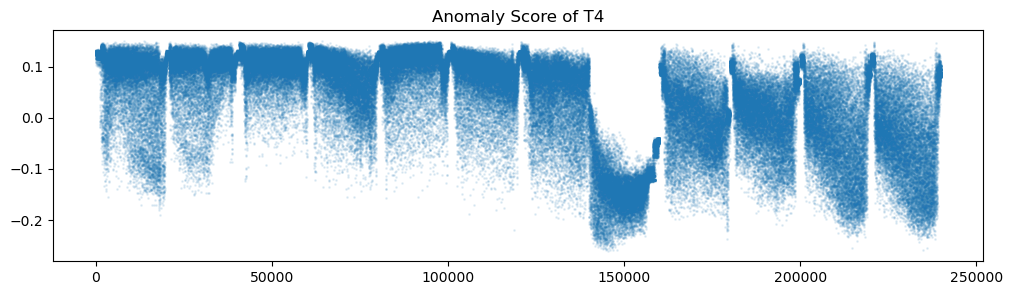

In [11]:
# T4의 anomaly score
scores = clf.decision_function(scaler.transform(Tx.drop(columns=['Expt']).to_numpy()))

plt.figure(figsize=(12, 3))
plt.scatter(range(len(scores)), scores, s=1, alpha=0.1)
plt.title(f'Anomaly Score of T4')
plt.show()

In [12]:
scores_t4 = scores

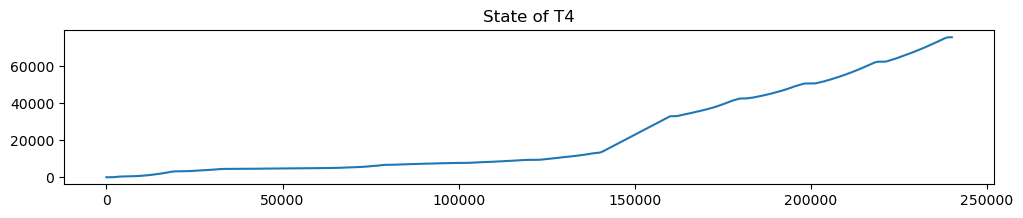

In [13]:
# Anomaly score -> Health index (state)
state_t4 = health_index(-scores_t4, th=0, increase_step=1, decrease_step=0.001)

plt.figure(figsize=(12, 2))
plt.plot(state_t4)
plt.title(f'State of T4')
plt.show()